# Visibility tool

adapted from https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

In [1]:
#
# General imports we will use at some point
#
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)

import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

# Pre-defined constants - do not change these

In [2]:
madison_wi = EarthLocation(lat=43.07442*u.deg, lon=-89.40501*u.deg, height=280*u.m)

# Adapt these values for your target and observing night

In [15]:
# target name
target_name = "M 51"

# observing night
midnight = Time('2023-10-20') 

# Set the UTC offset according to current Daylight Saving Time (comment out the wrong line)
utcoffset = -5*u.hour  # Central Daylight Time
# utcoffset = -6*u.hour # Central Standard Time

# This is where the action is

Now we can add some calculations to work out where on the sky our target will be throughout the night. 

In [16]:
# calculate where on the sky the target will be, for a number of steps throughout the night
target = SkyCoord.from_name(target_name)
delta_midnight = np.linspace(-7, 7, 200)*u.hour
observing_times = midnight - utcoffset + delta_midnight
observing_night = AltAz(obstime=observing_times,
                          location=madison_wi)
target_altaz = target.transform_to(observing_night)

In [17]:
# convert alt, az to airmass with secz attribute:
target_airmass = target_altaz.secz

# since airmass behaves funky when the object is below the horizon, let's replace these values
target_airmass[ target_altaz.alt <= 0 ] = 10

In [18]:
# Repeat same calculations for the moon
from astropy.coordinates import get_body
moon = get_body("moon", observing_times)
moon_altaz = moon.transform_to(observing_night)
moon_airmass = moon_altaz.secz
# moon_airmass[ (moon_airmass < 0) | (moon_airmass > 10) ] = 10
moon_airmass[ (moon_altaz.alt <= 0) ] = 10
# print(moon_airmass)

# also interesting is the distance between target and the moon
# Question: Why is this, and what values are good/problematic? 
distance_to_moon = [t.separation(m)/u.deg for t,m in zip(target_altaz, moon_altaz)]

In [19]:
delta_midnight_sun = np.linspace(-7,7,1000)*u.hour 
sun_gradient_times = midnight - utcoffset + delta_midnight_sun
sun = get_body("sun", sun_gradient_times)
sun_altaz = sun.transform_to(AltAz(obstime=sun_gradient_times, location=madison_wi))

max_alpha = 0.7
sun_alpha = (-18. - np.array(list(sun_altaz.alt/u.deg))) / (-18./max_alpha)
sun_alpha[sun_alpha < 0] = 0.
sun_alpha[sun_alpha > max_alpha] = max_alpha
sun_colors = np.ones((delta_midnight_sun.shape[0],4)) * [0.2,0.4,0.8,1]
sun_colors[:,3] = sun_alpha

# Plot the airmass as a function of time

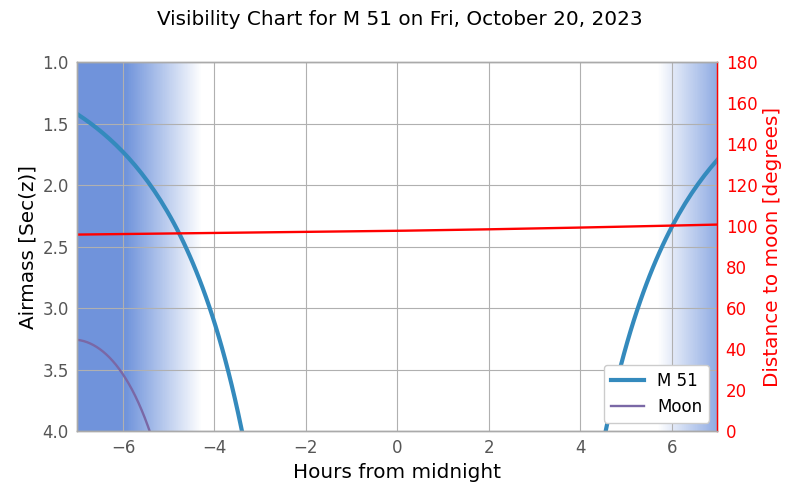

In [20]:
fig,ax = plt.subplots(1, figsize=(8,5), tight_layout=True)
fig.suptitle("Visibility Chart for %s on %s" % (target_name, midnight.strftime("%a, %B %-d, %Y")))
ax.plot(delta_midnight, target_airmass, label=target_name, linewidth=3)
ax.plot(delta_midnight, moon_airmass, label="Moon")
ax.set_xlim(-7,7)
ax.set_ylim(4,1)
ax.set_xlabel('Hours from midnight')
ax.set_ylabel('Airmass [Sec(z)]')

ax2 = ax.twinx()
ax2.set_ylim(0,180)
ax2.spines['right'].set_color('red')
# ax2.spines['top'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.plot(delta_midnight, distance_to_moon, c='red', label='distance to moon')
ax2.grid(False) #color="pink", alpha=0.5, zorder=5)
ax2.set_ylabel("Distance to moon [degrees]")

#ax.bar(delta_midnight, np.ones(delta_midnight.shape)*3+1, c='green')
ax.bar(delta_midnight_sun, height=3,bottom=1, 
       width=(delta_midnight_sun[1]-delta_midnight_sun[0])/u.hour, 
       color=sun_colors, zorder=-4)
ax.legend(loc='lower right', framealpha=1).set_zorder(99)